This notebook demonstrates how to use `firedrake-adjoint` to solve an adjoint equation (and extract the adjoint solution at each timestep).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

Import Firedrake with adjoint mode activated

In [2]:
from firedrake import *
from firedrake_adjoint import *

Define a simple mesh

In [3]:
n = 30
mesh = UnitSquareMesh(n, n)

Take the setup of the [Burgers equation](https://firedrakeproject.org/demos/burgers.py.html) demo and wrap it in a function which depends on the mesh, as well as the `Constant` diffusivity $\nu>0$ and some time integration parameters:

In [4]:
nu = Constant(0.0001)
dt = 1.0/n
end_time = 0.5
timesteps_per_export = 5  # For plotting

In [5]:
def solve_burgers(mesh2d, axs=None):
    
    # Function spaces
    V = VectorFunctionSpace(mesh2d, "CG", 2)
    u_ = Function(V)
    u = Function(V, name="Velocity")

    # Functions
    v = TestFunction(V)
    x, y = SpatialCoordinate(mesh2d)
    u_ = interpolate(as_vector([sin(pi*x), 0]), V)
    u.assign(u_)
    
    # Form
    F = (inner((u - u_)/dt, v) + inner(dot(u, nabla_grad(u)), v) + nu*inner(grad(u), grad(v)))*dx
    
    # Time integration loop
    i = 0
    t = 0.0
    while (t <= end_time):
        if axs is not None and i % timesteps_per_export == 0:
            tricontourf(u, axes=axs[i//timesteps_per_export])
        solve(F == 0, u)
        u_.assign(u)
        t += dt
        i += 1
        
    return u

Pass parameters to solve call

<IPython.core.display.Javascript object>


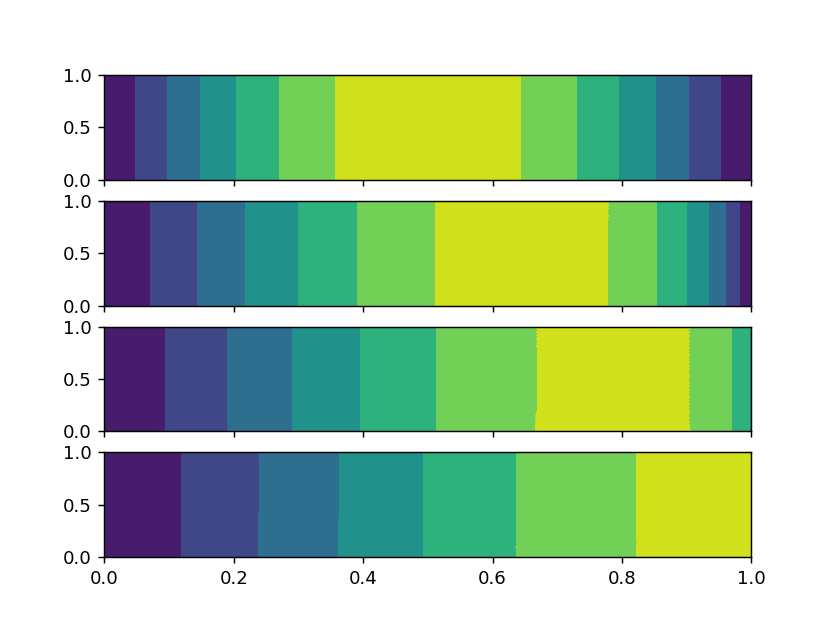

In [6]:
num_timesteps = int(end_time/dt)
num_exports = num_timesteps//timesteps_per_export + 1
fig, axs = plt.subplots(num_exports, sharex='col')
sol = solve_burgers(mesh, axs=axs)

Define an objective functional, in this case the norm
$$J(u)=\int_{\Gamma_2}u\cdot u\;\mathrm ds,$$
where $\Gamma_2=\{(1,y)|y\in(0,1)\}$

In [7]:
J = assemble(inner(sol, sol)*ds(2))

Tell `firedrake-adjoint` to stop annotating the tape

In [8]:
stop_annotating();

Get the working tape and take a look at its blocks. These correspond to the (high level) operations we've performed during the simulation. For example, value assignment, FEM solves and functional assembly.

In [9]:
tape = get_working_tape()
for i, block in enumerate(tape._blocks):
    print("Block {:2d}: {:}".format(i, type(block)))

Block  0: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  1: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  2: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  3: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  4: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  5: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  6: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  7: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block  8: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block  9: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block 10: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block 11: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block 12: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block 13: <class 'firedrake.adjoint.blocks.SolveVarFormBlock'>
Block 14: <class 'firedrake.adjoint.blocks.FunctionAssignBlock'>
Block 15: <class 'firedrake.adjoint.blo

Since $\nu$ is defined outside of the `solve_burgers` function, `firedrake-adjoint` enables us to compute the gradient $\partial J/\partial\nu$.
Whilst we don't actually need this, the computation endows the `SolveVarFormBlock`s with adjoint solutions.

In [10]:
g = compute_gradient(J, nu)
print("Gradient = {:.4f}".format(*g.values()))

Gradient = -8.5617


We are only interested in the blocks corresponding to FEM solves. Extract them and check that there are as many as we expect.

In [11]:
from firedrake.adjoint.blocks import SolveVarFormBlock

solve_blocks = [block for block in tape._blocks if isinstance(block, SolveVarFormBlock)]
assert len(solve_blocks) == num_timesteps + 1

Plot the adjoint solution, remembering that it propagates _backwards_ in time.

<IPython.core.display.Javascript object>


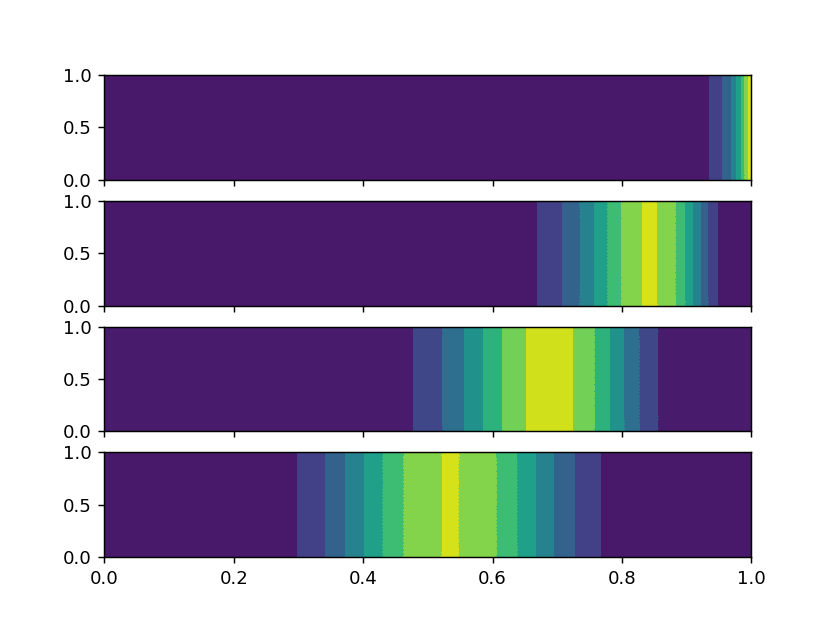

In [12]:
fig, axs = plt.subplots(num_exports, sharex='col')
for i in range(num_exports):
    tricontourf(solve_blocks[num_timesteps-timesteps_per_export*i].adj_sol, axes=axs[i]);